In [2]:
import pandas as pd
import json
import re
import os
import numpy as np
from sympy import Point3D, Line3D, Plane
import cv2 as cv

from functools import partial
import multiprocessing  
from multiprocessing import Pool
import Vuelosophy_IO.workers as workers
from classes import Class_device, Class_unity, Class_frame, Class_video

In [3]:
    #Eerste bestand uit de input_H264 map halen, om deze dan te processen
device_obj = Class_device()
device_obj.path = './Vuelosophy_IO/'

#H264
device_obj.input_path_h264 = device_obj.path + 'input_H264/'
filenames = os.listdir(device_obj.input_path_h264)


device_obj.input_file_h264 = filenames[0] # AANPASSEN
filenames[0] = filenames[0].rstrip(".h264")

#MP4
device_obj.output_path_mp4 = device_obj.path + 'output_MP4/'
device_obj.output_file_mp4 = filenames[0] + '.mp4'# AANPASSEN

#JSON
device_obj.output_path_json = device_obj.path + 'output_JSON/'
device_obj.output_file_json = filenames[0] + '.json' # AANPASSEN

#PKL
device_obj.output_path_pkl = device_obj.path + 'output_PKL/'
device_obj.output_file_pkl = filenames[0] + '.pkl' # AANPASSEN

In [4]:
# h264 bestand inlezen en omzetten naar een json bestand, om daar dan de data uit te halen
def h264_to_json(path_h264, file_h264, path_json, file_json):
    with open(path_h264 + file_h264, 'rb') as f:
        data = f.read()
    result = re.findall(b'(?<=\xff\xff\xff\xff\xff)\{.+?(?=\x00\x00\x00\x01)', data)
    result = [str(part)[2:-1] for part in result]
    regular_json = '[' + ',\n'.join(result) + ']'
    pretty_json = json.loads(regular_json)
    with open(path_json + file_json, 'w') as f:
        f.write(json.dumps(pretty_json, indent=4))
        
h264_to_json(device_obj.input_path_h264, device_obj.input_file_h264,  device_obj.output_path_json, device_obj.output_file_json)

In [5]:
def json_to_pandas_df(path_json, file_json):
    with open(path_json + file_json) as f:
        data = json.load(f)
    df_all = pd.json_normalize(data)
    return df_all

def split_all(df_all):
    df_header = df_all.iloc[0][['width', 'height', 'frame_rate', 'frame_total']]   
    df_header.rename({'width': 'frame_width', 'height': 'frame_height'}, inplace = True)
    
    df_header['frame_width'] = df_header['frame_width'].astype(int)
    df_header['frame_height'] = df_header['frame_height'].astype(int)
    df_header['frame_total'] = df_header['frame_total'].astype(int)

    df_body = df_all.iloc[1:][['num', 'ft.x', 'ft.y', 'ft.z']]
    df_body.rename(columns={'num': 'frame_number', 'ft.x': 'norm_eye_3d_x', 'ft.y': 'norm_eye_3d_y', 'ft.z': 'norm_eye_3d_z'}, inplace=True)
    df_body['frame_number'] = df_body['frame_number'].astype(int)
    
    return df_header, df_body
df_header, df_body = split_all(json_to_pandas_df(device_obj.output_path_json, device_obj.output_file_json))

In [6]:
df_header

frame_width        640
frame_height       480
frame_rate      60.108
frame_total       1728
Name: 0, dtype: object

In [6]:
df_body

,frame_number,norm_eye_3d_x,norm_eye_3d_y,norm_eye_3d_z
1,0,0.273610,-0.305020,1.381467
2,1,0.273610,-0.305020,1.381467
3,2,0.272946,-0.305596,1.383329
4,3,0.268329,-0.309555,1.396922
5,4,0.268329,-0.309555,1.396922
...,...,...,...,...
1723,1722,0.210475,-0.353606,1.557996
1724,1723,0.210475,-0.353606,1.557996
1725,1724,0.220235,-0.342439,1.399009
1726,1725,0.229879,-0.328489,1.308425


In [7]:
# Frame object -> zou kunnen we gemakkelijk aan alle nodige data voor bepaalde functies
frame_obj = Class_frame()
frame_obj.width = df_header['frame_width']
frame_obj.height = df_header['frame_height']
frame_obj.rate = df_header['frame_rate']
frame_obj.total = df_header['frame_total']
# frame_obj.number = df_body['frame_number']
# frame_class.timestamp = round(frame_class.number / frame_class.rate, 3)

In [8]:
unity_obj = Class_unity()
unity_obj.width = 13.333
unity_obj.height = 10
unity_obj.distance= 12.678

In [9]:
video_obj = Class_video()
video_obj.window_name = 'eye tracking (Vuelosophy)' # AANPASSEN
video_obj.nr_of_frames = frame_obj.total - 2
video_obj.input_file = device_obj.input_path_h264 + device_obj.input_file_h264
video_obj.output_file = device_obj.output_path_mp4 + device_obj.output_file_mp4

***

## Preprocessing

In [10]:
def multiproc(func, data, cores = 0):
    if __name__ == '__main__':
        pool = None
        if cores > 0:
            print("using %s cores"%cores)
            pool = Pool(cores)
        else:
            print("using all cores")
            pool = Pool()
        print("start processing ")
        results = pool.map(func, data)
        return results

In [1]:
df_body

NameError: name 'df_body' is not defined

In [11]:
columns = df_body.columns.values.tolist()
columns.append("px_eye_2d_x")
columns.append("px_eye_2d_y")

data = df_body.values.tolist()
func = partial(workers.coord_3d_to_2d, unity_obj, frame_obj)
new_data = multiproc(func, data)

df_body = pd.DataFrame(new_data, columns=columns)

using all cores
start processing 


In [12]:
df_body.drop(["norm_eye_3d_x", "norm_eye_3d_y", "norm_eye_3d_z"], axis=1, inplace=True)

In [13]:
df_body

,frame_number,px_eye_2d_x,px_eye_2d_y
0,0.0,199.470239580704,105.636970785404
1,1.0,199.470239580704,105.636970785404
2,2.0,199.924585388523,105.564437509804
3,3.0,203.104364217807,105.147919554564
4,4.0,203.104364217807,105.147919554564
...,...,...,...
1722,1722.0,237.787657630370,101.883592984834
1723,1723.0,237.787657630370,101.883592984834
1724,1724.0,224.199302155338,91.0451335080760
1725,1725.0,213.081389035987,87.2208876962760


## Oog fixaties berekenen

In [14]:
def fixations(row, threshhold):
    if row.eye_dist <= threshhold:
        return 1
    else:
        return 0

def get_fixations(df_body):
    df_body['px_eye_2d_x2'] = df_body['px_eye_2d_x'].shift(-1)
    df_body['px_eye_2d_y2'] = df_body['px_eye_2d_y'].shift(-1)
    df_body = df_body[:-1] #laatste row deleten omdat het nu lege waarden bevat
    
    df_body['eye_dist'] = ((df_body['px_eye_2d_x2'] - df_body['px_eye_2d_x'])**2) + ((df_body['px_eye_2d_y2'] - df_body['px_eye_2d_y2'])**2 )
    q1 = np.percentile(df_body['eye_dist'], 25)
    q3 = np.percentile(df_body['eye_dist'], 75)
    threshhold= q3 + (1.5 * (q3 - q1))
    df_body['Fixation'] = df_body.apply(lambda x:fixations(x, threshhold), axis=1)
    df_body.drop(["px_eye_2d_x2", "px_eye_2d_y2"], axis=1, inplace=True)
    
    return df_body
df_body = get_fixations(df_body)

c:\users\robbe brandse\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
c:\users\robbe brandse\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
c:\users\robbe brandse\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set 

In [15]:
df_body

,frame_number,px_eye_2d_x,px_eye_2d_y,eye_dist,Fixation
0,0.0,199.470239580704,105.636970785404,0,1
1,1.0,199.470239580704,105.636970785404,0.206430113082218,1
2,2.0,199.924585388523,105.564437509804,10.1109934031629,1
3,3.0,203.104364217807,105.147919554564,0,1
4,4.0,203.104364217807,105.147919554564,4.93416638656290,1
...,...,...,...,...,...
1721,1721.0,242.554452174718,101.401189688395,22.7223302280233,1
1722,1722.0,237.787657630370,101.883592984834,0,1
1723,1723.0,237.787657630370,101.883592984834,184.643404515822,0
1724,1724.0,224.199302155338,91.0451335080760,123.607992129446,1


## Object detection

In [16]:
def labelimg(img, data):
    height, width, channels = img.shape

    # Detecting objects
    blob = cv.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # Showing informations on the screen
    class_ids, confidences, boxes = [], [], []
    # confidences = []
    # boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.3:
                # Object detected
#                 print(class_id)
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
                

    indexes = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
#     print(indexes)
    font = cv.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv.putText(img, label, (x, y + 30), font, 2, color, 2)

            if int(data["px_eye_2d_x"]) in range(x, x + w) and int(data["px_eye_2d_y"]) in range(y, y + h):
                print("looking at: %s        " % (label), end="\r")
                data["objectId"] = class_ids[i]
                data["object"] = classes[int(class_ids[i])]

    return img, data

In [17]:
def create_video(data, video, frame):
    if os.path.exists(video.output_file):
        os.remove(video.output_file)

    cv.namedWindow(video.window_name)

    cap = cv.VideoCapture(video.input_file)
    codec = cv.VideoWriter_fourcc('m', 'p', '4', 'v')
    out = cv.VideoWriter(video.output_file, codec, frame.rate, (frame.width, frame.height))  # MP4
    
    df_body["objectId"] = np.nan
    df_body["object"] = np.nan
    current_frame = 0
    try:
        while cap.isOpened():
            ret, img = cap.read()
            if ret is True and current_frame < video.nr_of_frames:
                if data['Fixation'][current_frame] == 1: #wel een fixation
                    img, serie = labelimg(img, data.iloc[[current_frame]])
                    data.iloc[[current_frame]] = serie
                    cv.circle(img, (data["px_eye_2d_x"][current_frame], data["px_eye_2d_y"][current_frame]), 30, (255, 255, 255), 3)
                
                if data['Fixation'][current_frame] == 0: #geen fixation
                    cv.circle(img, (data["px_eye_2d_x"][current_frame], data["px_eye_2d_y"][current_frame]), 30, (0, 0, 255), 3)
                
                out.write(img)
                cv.imshow(video.window_name, img)
                
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
                current_frame = current_frame + 1
            else:
                break

        cap.release()
        out.release()
        cv.destroyAllWindows()
    except Exception as e:
        print('error')
        print(e)
        cap.release()
        out.release()
        cv.destroyAllWindows()
    return data

In [18]:
#model goedzetten
net = cv.dnn.readNet("weights/TinyWeightsV4.weights", "configs/TinyConfig.cfg")  # weight en configuration file ophalen
classes = ["Jam", "Knife", "Bread", "Choco"]

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

df_body = create_video(df_body, video_obj, frame_obj)

c:\users\robbe brandse\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
c:\users\robbe brandse\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


c:\users\robbe brandse\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\robbe brandse\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\users\robbe brandse\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

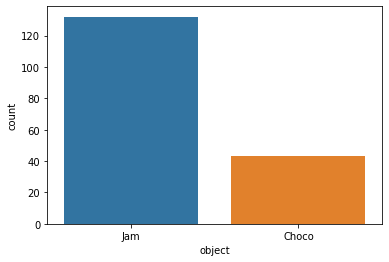

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data = df_body, x="object")

In [20]:
def gantplot(df_body):
    usefull = df_body.dropna()
    viewed_classes = usefull['object'].unique()
    graph_data = {}
    for classname in viewed_classes:
        graph_data[classname]= usefull[usefull['object'] == classname]
        
    fig, gnt = plt.subplots() 

    gnt.set_yticks(np.arange(10, len(viewed_classes)*10+1,10))
    gnt.set_yticklabels(viewed_classes) 
    gnt.set_xlabel('tijdverloop') 

    gnt.set_yticklabels(viewed_classes) 
    gnt.grid(True) 

    colors= ['tab:blue','tab:red','tab:purple','tab:orange']
    for key, val in graph_data.items():
        output = [(row['frame_number'], 1) for index, row in val.iterrows()]
        nr = list(viewed_classes).index(key)
        gnt.broken_barh(output, (nr*10 + 5, 10),facecolors =colors[nr] )
    plt.show()

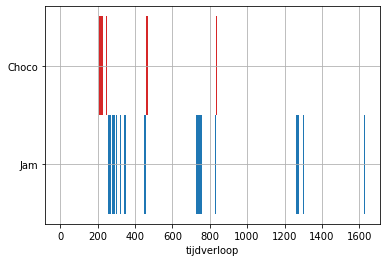

In [21]:
gantplot(df_body)

In [24]:
def interpolate(data, max_pointRange):
    previous_point = {"index": 0, "object": None}
    for index, row in data.iterrows():
        if previous_point['object'] == None and row['object'] != None:
            previous_point['object'] = row['object']
            previous_point['index'] = row['frame_number']

        if row['object'] != None:
            if previous_point['object'] == row['object']:
                if int(row['frame_number'] - previous_point['index']) in range(2, max_pointRange+1):
                    for frame in range(int(previous_point['index'] +1) , int(row['frame_number'])):
                        data.at[frame, "object"] = row['object']
                        data.at[frame, "objectId"] = classes.index(row['object'])

                previous_point['object'] = row['object']
                previous_point['index'] = row['frame_number']
    return data

df_body = interpolate(df_body, 30)

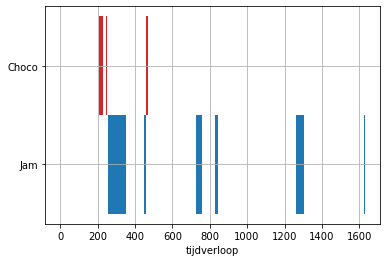

In [25]:
gantplot(df_body)